# Recommendations with IBM

In this notebook, I will be putting my recommendation skills to use on real data from the IBM Watson Studio platform.

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>

In [18]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import progressbar
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import project_tests as t

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download(['punkt', 'wordnet', 'stopwords',
               'averaged_perceptron_tagger'])

# Pretty display for notebooks
%matplotlib inline
%config InlineBachend.figure_format = 'retina'

# Enable pep8 code style test
#%load_ext pycodestyle_magic

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Load the nessesary data.
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

In [4]:
# Check null values in df
df.isnull().sum()

article_id     0
title          0
email         17
dtype: int64

In [5]:
# Check null values in df_content
df_content.isnull().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

In [6]:
# Count user interaction
user_interaction = df.email.value_counts(dropna=False)

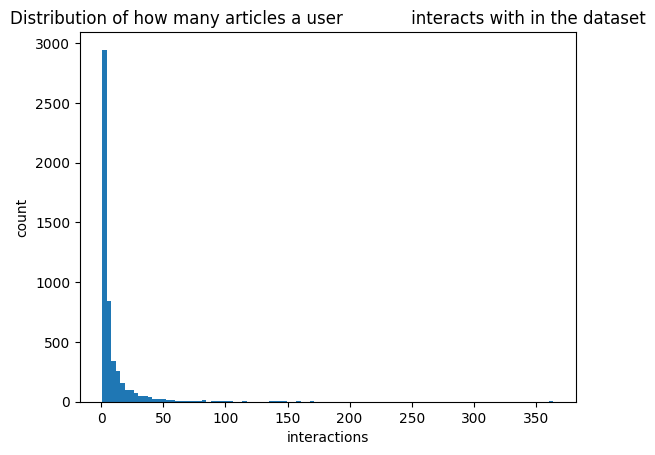

In [7]:
# Distribution of how many articles a user interacts with in the dataset
plt.figure()
plt.hist(user_interaction.values, bins=100)
plt.title('Distribution of how many articles a user \
            interacts with in the dataset')
plt.xlabel('interactions')
plt.ylabel('count')
plt.show()

In [9]:
most_articles = df.article_id.value_counts(dropna=False)

cum_user = np.cumsum(most_articles.values)

# 50% of individuals interact with ____ number of articles or fewer.
median_val = len(cum_user[cum_user <= len(user_interaction)/2])

# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = user_interaction.iloc[0]

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [10]:
# Find and explore duplicate articles
article_count = df_content.article_id.value_counts(dropna=False)
dup_articles = article_count[article_count > 1]

print('number of duplicate articles is: ', len(dup_articles))

number of duplicate articles is:  5


In [11]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], inplace=True)

In [12]:
# The number of unique articles that have at least one interaction
unique_articles = len(most_articles)

# The number of unique articles on the IBM platform
total_articles = df_content.shape[0]

# The number of unique users
unique_users = len(user_interaction)-1

# The number of user-article interactions
user_article_interactions = len(df)

In [13]:
# The most viewed article in the dataset
# as a string with one value following the decimal
most_viewed_article_id = str(most_articles.index[0])
# The most viewed article in the dataset was viewed how many times?
max_views = most_articles.iloc[0]

In [14]:
# Map the user email to a user_id column and remove the email column


def email_mapper():
    '''
    Map the user email to a user_id column and remove the email column
    '''

    coded_dict = dict()
    cter = 1
    email_encoded = []

    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter += 1

        email_encoded.append(coded_dict[val])

    return email_encoded


email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [19]:
# Test values
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.


In [52]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles

    '''

    # Get articles ids
    user_by_article = df.groupby(['user_id',
                                  'article_id'])['title'].count().unstack()
    articles_interaction = user_by_article.sum().sort_values(ascending=False)
    articles_index = articles_interaction.iloc[:n].index

    # Get articles titles
    df_art_title = df.drop_duplicates(subset=['article_id'])[['article_id',
                                                              'title']]
    df_art_title.index = df_art_title.article_id

    # get list of the top n article titles
    top_articles = list(df_art_title.loc[articles_index].title)

    return top_articles


def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles

    '''

    user_by_article = df.groupby(['user_id',
                                  'article_id'])['title'].count().unstack()
    articles_interaction = user_by_article.sum().sort_values(ascending=False)
    top_articles = list(articles_interaction.iloc[:n].index)

    return top_articles  # Return the top article ids

In [53]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [54]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` I will Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**.


In [55]:
# create the user-article matrix with 1's and 0's


def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns

    OUTPUT:
    user_item - user item matrix

    Description:
    Return a matrix with user ids as rows and article ids on the columns
    with 1 values where a user interacted with an article and a 0 otherwise
    '''

    # Fill in the function here
    user_item = df.groupby(['user_id',
                            'article_id'])['title'].agg(lambda x: 1).unstack()
    user_item.fillna(0, inplace=True)

    return user_item  # return the user_item matrix


user_item = create_user_item_matrix(df)

# save the matrix in a pickle file
user_item.to_pickle('user_item_matrix.p')

In [56]:
# Tests
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."

print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [57]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    similar_users - (list) an ordered list where the closest users
                    (largest dot product users) are listed first

    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered

    '''

    # Compute similarity of each user to the provided user
    user_vector = np.array(user_item.loc[user_id]).reshape(-1, 1)
    Matrix_item = user_item.drop(user_id)
    similarity = np.dot(Matrix_item.values, user_vector)
    # sort by similarity
    df_smly = pd.DataFrame({'user_id': Matrix_item.index,
                            'similarity': similarity.flatten()})
    df_smly.sort_values(by=['similarity'], inplace=True, ascending=False)

    # Create list of just the ids
    most_similar_users = list(df_smly.user_id)

    return most_similar_users

In [58]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(
    find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(
    find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(
    find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that I have a function that provides the most similar users to each user, I will  use these users to find articles I can recommend.

In [59]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids (str)
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    article_names - (list) a list of article names associated with the list
                     of article ids (this is identified by the title column)
    '''

    article_ids = [float(x) for x in article_ids]
    df_2 = df.drop_duplicates(subset=['article_id'])
    df_2.set_index('article_id', inplace=True)
    article_names = list(df_2.loc[article_ids]['title'])

    return article_names


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with
                    the list of article ids

    Description:
    Provides a list of the article_ids and article titles that have
    been seen by a user
    '''
    row_user = user_item.loc[user_id]
    article_ids = list(row_user[row_user > 0].index)
    article_ids = [str(x) for x in article_ids]
    article_names = get_article_names(article_ids)
    return article_ids, article_names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and
                    provides them as recs
    Does this until m recommendations are found

    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user

    For the user where the number of recommended articles starts below m
    and ends exceeding m, the last items are chosen arbitrarily

    '''

    # Get user articles
    article_ids, _ = get_user_articles(user_id)
    # Find similar users
    most_similar_users = find_similar_users(user_id)
    # How many users for progress bar
    n_users = len(most_similar_users)

    recs = []
    # Create the progressbar
    cnter = 0
    bar = progressbar.ProgressBar(maxval=n_users+1,
                                  widgets=[progressbar.Bar('=', '[', ']'),
                                           ' ', progressbar.Percentage()])
    bar.start()

    for user in most_similar_users:

        # Update the progress bar
        cnter += 1
        bar.update(cnter)

        # Get user articles
        ids, _ = get_user_articles(user)
        article_not_seen = np.setdiff1d(np.array(ids), np.array(article_ids))
        article_not_recs = np.setdiff1d(article_not_seen, np.array(recs))
        recs.extend(list(article_not_recs))

        # If there are more than
        if len(recs) > m:
            break

    bar.finish()

    recs = recs[:10]

    return recs

In [60]:
# Check Results
get_article_names(user_user_recs(1, 10))

[========================================================================] 100%


['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\r\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\r\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [61]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0','1422.0','1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [102]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook
    user_item - (pandas dataframe) matrix of users by articles:
            1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each
                                 user to the provided user_id
                    num_interactions - the number of articles viewed
                                       by the user - if a u

    Other Details - sort the neighbors_df by the similarity and then by number
               of interactions where highest of each is higher in the dataframe

    '''

    # similarity
    user_vector = np.array(user_item.loc[user_id]).reshape(-1, 1)
    Matrix_item = user_item.drop(user_id)
    similarity = np.dot(Matrix_item.values, user_vector)
    # sort by similarity
    df_smly = pd.DataFrame({'neighbor_id': Matrix_item.index,
                            'similarity': similarity.flatten()})

    # Number of interaction
    count_inter = df.groupby('user_id').count()['article_id']
    df_inter = pd.DataFrame({'neighbor_id': count_inter.index,
                             'num_interactions': count_inter.values})

    # Merging the two dataframes
    neighbors_df = df_smly.merge(df_inter)

    # sort the neighbors_df
    neighbors_df.sort_values(by=['similarity', 'num_interactions'],
                             inplace=True, ascending=False)

    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and
                    provides them as recs
    Does this until m recommendations are found

    Notes:
    * Choose the users that have the most total article interactions
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions
    before choosing those with fewer total interactions.

    '''
    # get user articles
    article_ids, _ = get_user_articles(user_id)
    # find similar users
    most_similar_users = list(get_top_sorted_users(user_id).neighbor_id)
    # How many users for progress bar
    n_users = len(most_similar_users)

    recs = []
    # Create the progressbar
    cnter = 0
    bar = progressbar.ProgressBar(maxval=n_users+1,
                                  widgets=[progressbar.Bar('=', '[', ']'), ' ',
                                           progressbar.Percentage()])
    bar.start()

    for user in most_similar_users:

        # Update the progress bar
        cnter += 1
        bar.update(cnter)

        # get user articles
        ids, _ = get_user_articles(user)
        article_not_seen = np.setdiff1d(np.array(ids), np.array(article_ids))
        article_not_recs = np.setdiff1d(article_not_seen, np.array(recs))
        recs.extend(list(article_not_recs))

        # If there are more than
        if len(recs) > m:
            break

    bar.finish()

    recs = recs[:10]
    rec_names = get_article_names(recs)

    return recs, rec_names

In [103]:
# Quick spot check
rec_ids, rec_names = user_user_recs_part2(10, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

[========================================================================] 100%


The top 10 recommendations for user 20 are the following article ids:
['1044.0', '1047.0', '1053.0', '111.0', '1160.0', '1162.0', '1163.0', '1164.0', '1165.0', '1166.0']

The top 10 recommendations for user 20 are the following article names:
['mapping points with folium', 'a comparison of logistic regression and naive bayes ', 'access mysql with python', 'tidy up your jupyter notebooks with scripts', 'analyze accident reports on amazon emr spark', 'analyze energy consumption in buildings', 'analyze open data sets with spark & pixiedust', 'analyze open data sets with pandas dataframes', 'analyze precipitation data', 'analyzing data by using the sparkling.data library features']


In [104]:
# Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1).neighbor_id.values[0] # Find the user that is most similar to user 1
user131_10th_sim = get_top_sorted_users(131).neighbor_id.values[9] # Find the 10th most similar user to user 131

In [105]:
# Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim,
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


For a new user, we can use **get_top_articles** function to suggest top articles.

We can improve our recommendations for a new user by using a **Knowledge-Based Recommendations** where we will ask the user to provide pieces of information about the types of articles they are interested in and look throughout our data for articles that meet the user specifications.  

In [106]:
new_user = '0.0'

# List of the top 10 article ids you would give to
new_user_recs = [str(x) for x in get_top_article_ids(10)]

In [107]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.

In [108]:
def tokenize(text):
    """Function to tokenize an article title

    Args:
        text (str) title

    return:
        tokens (list) a list of words

    """

    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

    # tokenize text
    tokens = word_tokenize(text)

    # lemmatize and remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens
              if word not in stop_words]
    # remove short words
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

In [109]:
def create_article_content_dataframe(df=df, df_content=df_content):
    '''
    INPUT:
    df - pandas dataframe describe user interaction with th articles
    df_content - pandas dataframe describe articles on the platforme
    OUTPUT:
    df_total - pandas dataframe contains all articles in the platforme
    article_content -  pandas dataframe describe the content of each
                       article on the plateforme

    Description:
    Return a pandas dataframe contains all the articles in the platforme
    with thier titles and a pandas dataframe describes the content of each
    article base on the article title.
    '''

    # Get a dataframe of the full articles
    df_1 = df[['article_id', 'title']]
    df_2 = pd.DataFrame({'article_id': df_content.article_id.values,
                         'title': df_content. doc_full_name})
    df_total = pd.concat([df_1, df_2], ignore_index=True)
    df_total.drop_duplicates(subset=['article_id'], inplace=True)
    df_total.sort_values(by='article_id', inplace=True)
    df_total.reset_index(drop=True, inplace=True)

    # TfidfVectorizer
    vectorizer = TfidfVectorizer(tokenizer=tokenize)
    df_vec = pd.DataFrame(vectorizer.fit_transform(
                          df_total.title.values).toarray(),
                          columns=[*vectorizer.vocabulary_])

    # concat  df_total and df_vec
    df_articles = pd.concat([df_total, df_vec], axis=1)

    return df_total, df_articles


df_total, df_articles = create_article_content_dataframe()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [110]:
df_total.head()

,article_id,title
0,0.0,detect malfunctioning iot sensors with streami...
1,1.0,Communicating data science: A guide to present...
2,2.0,"this week in data science (april 18, 2017)"
3,3.0,DataLayer Conference: Boost the performance of...
4,4.0,analyze ny restaurant data using spark in dsx


In [111]:
def create_article_similarity_dataframe(df=df_articles):
    '''
    INPUT:
    df - pandas dataframe describe articles content
    OUTPUT:
    article_content -  pandas dataframe describe articles similarities

    Description:
    Return a pandas dataframe that describe the articles similarities
    using the dot product.
    '''

    # subset articles content
    article_content = np.array(df_articles.iloc[:, 2:])

    # Take the dot product to obtain a article x article matrix of similarities
    dot_prod_article = article_content.dot(np.transpose(article_content))

    # checks the dot product
    assert dot_prod_article.shape[0] == len(df_articles)
    assert dot_prod_article.shape[1] == len(df_articles)

    # make a Dataframe
    article_similarity = pd.DataFrame(dot_prod_article,
                                      index=df_articles.article_id,
                                      columns=df_articles.article_id)

    return article_similarity


article_similarity = create_article_similarity_dataframe()

In [112]:
article_similarity.head()

article_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
article_id,,,,,,,,,,,,,,,,,,,,,
0.0,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1.0,0.0,1.000000,0.123927,0.0,0.027770,0.033650,0.0,0.032382,0.125929,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.032878,0.015730,0.0,0.0,0.0
2.0,0.0,0.123927,1.000000,0.0,0.039464,0.047820,0.0,0.046017,0.424907,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.046723,0.022353,0.0,0.0,0.0
3.0,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4.0,0.0,0.027770,0.039464,0.0,1.000000,0.041185,0.0,0.039633,0.040102,0.130353,...,0.0,0.0,0.0,0.0,0.0,0.040241,0.019252,0.0,0.0,0.0


In [113]:
def top_user_articles(user_id, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) dataframe of user interaction

    OUTPUT:
    article_ids - (list) a sorted list of the article ids seen by the user

    Description:
    Provides a list of the  article_ids sorted by interactions number
    '''

    df_user = df[df.user_id == 1]
    df_user = df_user.groupby('article_id').count()
    df_user.sort_values('user_id', ascending=False, inplace=True)

    count_article = df_user.user_id.unique()
    article_ids = []
    for k in count_article:
        ids = df_user[df_user.user_id == k].index
        article_ids.append(list(ids))

    return article_ids

In [114]:
def make_content_recs(user_id, m=10, df_smly=article_similarity, thd=1):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    df_smly - (pandas dataframe) pandas dataframe that describe the articles
    similarities using the dot product

    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    '''

    list_ids = top_user_articles(user_id)
    recs = []

    for ids in list_ids:
        top_articles = article_similarity.loc[ids].sum()
        top_articles.sort_values(ascending=False, inplace=True)
        top_articles = top_articles[top_articles >= thd]
        article_not_recs = np.setdiff1d(np.array(top_articles.index),
                                        np.array(recs))
        recs.extend(list(article_not_recs))

        # If there are more than
        if len(recs) > m:
            break

    recs = recs[:10]
    rec_names = get_article_names(recs, df=df_total)

    return recs, rec_names

### Discussion
In order to build content-based Recommendations, I have used the **doc_full_name** variable to compute similarities between articles because it doesn't contain any Null value and it gives a good description of the article content.

Using the natural language processing technics and the dot product I built an articles similarity matrix.

Given a user id, we can make recommendations by looking for most similar articles to the articles seen by the user.

In [115]:
# Get user id who only has interacted with article id '1427.0'
df_1427 = df[df.article_id == 1427.0].groupby('user_id').count()
user_1427 = df_1427.sort_values('article_id').index[0]

# Make recomendation
make_content_recs(user_1427)

([310.0, 585.0, 668.0, 1052.0, 1170.0, 1183.0, 1185.0, 1363.0, 1406.0, 1430.0],
 ['time series prediction using recurrent neural networks (lstms)',
  'tidyverse practice: mapping large european cities',
  'shiny: a data scientist’s best friend',
  'access db2 warehouse on cloud and db2 with python',
  'apache spark lab, part 1: basic concepts',
  'categorize urban density',
  'classify tumors with machine learning',
  'predict loan applicant behavior with tensorflow neural networking',
  'uci: iris',
  'using pixiedust for fast, flexible, and easier data analysis and experimentation'])

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, I will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.


In [116]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [117]:
# Quick look at the matrix
user_item_matrix.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
# Perform SVD on the User-Item Matrix Here

# use the built in to get the three matrices
u, s, vt = np.linalg.svd(user_item_matrix)
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

The lesson provides a data structure with numeric values representing a rating and nulls representing non-interaction.  This is not a matrix in the linear algebra sense and cannot be operated on (eg by SVD).  Funk SVD would have to be used to provide a numeric approximation.

The matrix in this exercise contains binary values with a zero representing non-interaction and a one representing interaction.  Although not invertible, this matrix can be factored by SVD.

Text(0.5, 1.0, 'Accuracy vs. Number of Latent Features')

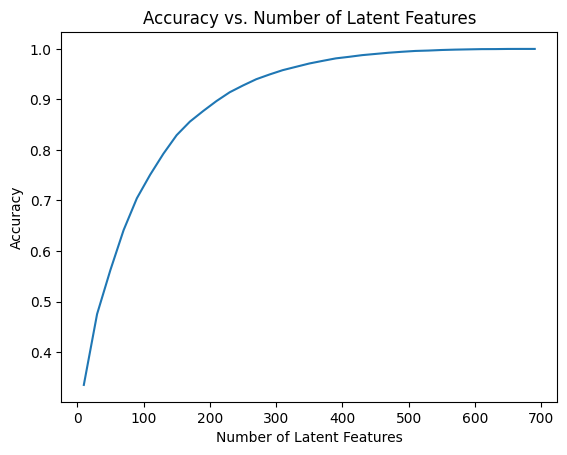

In [119]:
num_latent_feats = np.arange(10, 700+10, 20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)

    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)


plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0])
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')

 From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  


In [120]:
df_train = df.head(40000)
df_test = df.tail(5993)


def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe

    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe
                      (unique users for each row and unique articles
                       for each column)
    user_item_test - a user-item matrix of the testing dataframe
                    (unique users for each row and unique articles for
                     each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids

    '''

    # user-item matrix of the training dataframe
    user_item_train = create_user_item_matrix(df_train)

    # user-item matrix of the testing dataframe
    user_item_test = create_user_item_matrix(df_test)

    test_idx = list(user_item_train.index)  # test user ids
    test_arts = list(user_item_train.columns)  # test article ids

    return user_item_train, user_item_test, test_idx, test_arts


user_item_train, user_item_test, test_idx, \
    test_arts = create_test_and_train_user_item(df_train, df_test)

In [121]:
user_item_train.shape

(4487, 714)

In [122]:
user_item_test.shape

(682, 574)

In [123]:
len(np.setdiff1d(user_item_test.index, user_item_train.index))

662

In [124]:
len(np.setdiff1d(user_item_test.columns, user_item_train.columns))

0

In [125]:
# Replace the values in the dictionary below
a = 662
b = 574
c = 20
d = 0


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


In [126]:
# Fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [127]:
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [128]:
# Subset of rows in the user_item_test dataset that you can predict

#  Rows that match the test set
test_idx = user_item_test.index
row_idxs = user_item_train.index.isin(test_idx)
u_test = u_train[row_idxs, :]

#  Columns that match the test set
test_col = user_item_test.columns
col_idxs = user_item_train.columns.isin(test_col)
vt_test = vt_train[:, col_idxs]

In [129]:
# Test data
train_idx = user_item_train.index
row_idxs_2 = user_item_test.index.isin(train_idx)
sub_user_item_test = user_item_test.loc[row_idxs_2]

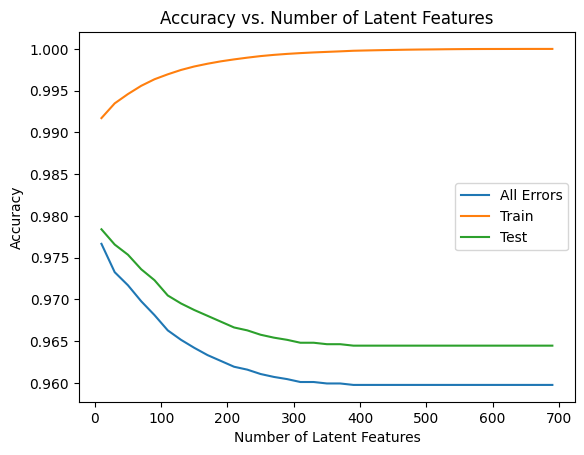

In [130]:
latent_feats = np.arange(10, 700+10, 20)

all_errs, train_errs, test_errs = [], [], []


for k in latent_feats:
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]

    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]

    # take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))

    all_errs.append(1 - ((np.sum(user_item_test_preds)+np.sum(np.sum(sub_user_item_test)))/(sub_user_item_test.shape[0]*sub_user_item_test.shape[1])))

    # compute prediction accuracy
    train_errs.append(accuracy_score(user_item_train.values.flatten(), user_item_train_preds.flatten()))
    test_errs.append(accuracy_score(sub_user_item_test.values.flatten(), user_item_test_preds.flatten()))


plt.figure()
plt.plot(latent_feats, all_errs, label='All Errors')
plt.plot(latent_feats, train_errs, label='Train')
plt.plot(latent_feats, test_errs, label='Test')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()

The figure above shows that in overall the accuracy of the model is very high. But it is a misleading result because we have a class imbalance in your data. In fact, the data contain much more zeros than ones.

The training accuracy increase to near 100% as the number of latent features increases. While the testing accuracy decrease as the number of latent features increases. This could be due to a limited variety in the datasets. A solution to this problem could be to perform Cross Validation to determine the number of latent features which allow the model to see different subsets of the datasets.

In [131]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

255